In [1]:
import matplotlib.pyplot as plt
import copy
import numpy as np
from PIL import Image

In [2]:
from sklearn.datasets import load_boston, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X, y = load_boston(return_X_y=True)
# X, y = fetch_california_housing(return_X_y=True)
X, y = scaler_x.fit_transform(X), scaler_y.fit_transform(y[:, None])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
poly = PolynomialFeatures(2)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((354, 105), (152, 105), (354, 1), (152, 1))

100 0.01366
200 0.01082



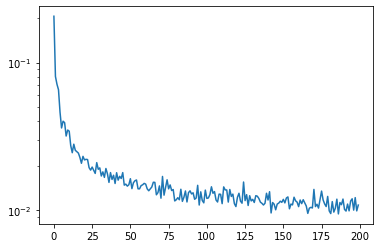

MAE error 0.07233935594558716


In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm

# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Hyper-parameters 
input_size = X_train.shape[-1]
hidden_size = 50
num_classes = 1
num_epochs = 200
# num_epochs = 1
batch_size = 200
learning_rate = 0.01
dropout_prob = 0.3


def get_dataset(X, y):
    return torch.utils.data.TensorDataset(torch.Tensor(X).to(device), torch.Tensor(y).to(device))


# dataset 
train_dataset = get_dataset(X_train, y_train)

test_dataset = get_dataset(X_test, y_test)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Fully connected neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.dropout0 = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(input_size, hidden_size) 
#         self.relu1 = nn.Sigmoid()
        self.relu1 = nn.PReLU()
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size, hidden_size)  
#         self.relu2 = nn.Sigmoid()
        self.relu2 = nn.PReLU()
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.dropout0(x)
        out = self.fc1(out)
        out = self.relu1(out)
#         out = self.dropout1(out)
#         out = self.fc2(out)
#         out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return out

model = NeuralNet(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# Train the model
total_step = len(train_loader)
losses = []
for epoch in tqdm(range(num_epochs)):
    cur_loss = 0.0
    sum_length = 0
    for i, (data, answers) in enumerate(train_loader):  
        
        outputs = model(data)
        mrt = (torch.abs(answers - answers.mean()).mean() * 10.0 + 1e-5)
        loss = criterion(outputs, answers)# + (((outputs - outputs.mean()) / mrt) ** 2).mean()
        cur_loss += float(loss.cpu().detach().numpy()) * data.shape[0]
        sum_length += data.shape[0]
        
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    cur_loss /= sum_length
    losses.append(cur_loss)
    optimizer.param_groups[0]['lr'] *= 0.99
    
    if epoch % 100 == 99:
        print(epoch + 1, round(cur_loss, 5))

plt.yscale('log')
plt.plot(losses)
plt.show()

with torch.no_grad():
    result_mse = 0.0
    sum_length = 0
    
    for data, answers in test_loader:
        outputs = model(data)
        result_mse += float(torch.abs(outputs - answers).mean().cpu().detach().numpy()) * data.shape[0]
        sum_length += data.shape[0]
        
    result_mse /= sum_length
        
    print(f"MAE error {result_mse}")

In [4]:
y.min(), y.max(), y.mean()

(0.0, 1.0, 0.3896179183135705)

In [5]:
outputs[:10]

tensor([[0.4216],
        [0.8056],
        [0.2579],
        [0.3946],
        [0.1550],
        [0.3410],
        [0.3453],
        [0.3059],
        [0.3458],
        [0.3038]], device='cuda:0')

In [6]:
#we need a portion of binary vectors to get a distribution of prediction
from scipy.stats import bernoulli

def bernoulli_diagonal(mat):
    samples = torch.Tensor(bernoulli.rvs(1 - dropout_prob, size=mat.shape[1])).to(device)
    return torch.diag(samples)

In [7]:
#actual distribution generation
def distr_gen(model, sample_image, T):
    distr = np.zeros((sample_image.shape[0], T, num_classes))
    for t in range(T):
        model_copy = copy.deepcopy(model)
    
        for linear_layer in [model_copy.fc1, model_copy.fc2, model_copy.fc3]:
            data = linear_layer.weight.data
            diag = bernoulli_diagonal(data)
            dropout_data = torch.matmul(data,diag)
            linear_layer.weight = nn.Parameter(dropout_data)
    
        distr[:, t, :] = model_copy(sample_image).cpu().detach().numpy()
    return distr

In [8]:
# xs, ys = torch.Tensor(X_train[:batch_size // 2]).to(device), y_train[:batch_size // 2]
xs, ys = torch.Tensor(X_test[100:100 + batch_size // 2]).to(device), y_test[100: 100 + batch_size // 2]
distrs = distr_gen(model, xs, 100)

In [9]:
distrs.shape

(52, 100, 1)

In [10]:
means = np.mean(distrs, axis=1)
stds = np.sqrt(((distrs - distrs.mean(axis=1, keepdims=True)) ** 2).mean(axis=1))
means[:5], stds[:5]

(array([[0.37157485],
        [0.39399267],
        [0.2643997 ],
        [0.36875033],
        [0.40889159]]),
 array([[0.04054389],
        [0.05383074],
        [0.04877713],
        [0.04289759],
        [0.04863063]]))

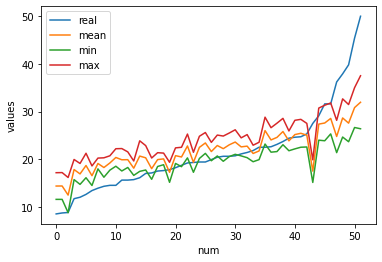

In [11]:
lst = [(ys[i], means[i], means[i] - stds[i], means[i] + stds[i]) for i in range(len(means))]
lst.sort()

def inverse(val):
#     return val
    return scaler_y.inverse_transform(np.array(val))[:, 0]

real_c = inverse([d[0] for d in lst])
mean_c = inverse([d[1] for d in lst])
min_c = inverse([d[2] for d in lst])
max_c = inverse([d[3] for d in lst])

plt.plot(real_c, label='real')
plt.plot(mean_c, label='mean')
plt.plot(min_c, label='min')
plt.plot(max_c, label='max')

plt.xlabel("num")
plt.ylabel("values")
plt.legend()
plt.show()